In [1]:
import pandas as pd
import numpy as np
from plotnine import *

In [15]:
cos_sim = pd.read_csv("/media/sayali/External Dr/Sayali/Foundation Models/scBrainLLM/results/pairwise_donor_cosine_similarity.csv", index_col=0)
cos_sim

,scGPT_scMulan,scGPT_UCE,scGPT_scFoundation,scGPT_Geneformer,scMulan_UCE,scMulan_scFoundation,scMulan_Geneformer,UCE_scFoundation,UCE_Geneformer,scFoundation_Geneformer,donor
0,0.969597,0.969978,0.907684,0.873854,0.988318,0.939603,0.915912,0.932049,0.910785,0.918617,M84161
1,0.972352,0.979712,0.879554,0.860970,0.987701,0.922054,0.908265,0.915917,0.903600,0.925946,M47108
2,0.946056,0.942913,0.912368,0.871957,0.983858,0.934763,0.936596,0.932420,0.943574,0.908418,M2646
3,0.964532,0.950776,0.911954,0.892499,0.985361,0.934927,0.939096,0.936028,0.952047,0.912841,M69259
4,0.963241,0.952827,0.900523,0.885921,0.987107,0.927783,0.934475,0.934105,0.945326,0.915967,M36121
...,...,...,...,...,...,...,...,...,...,...,...
1038,0.964969,0.958829,0.900775,0.892351,0.987519,0.923450,0.932451,0.925371,0.939446,0.910277,M93210
1039,0.945985,0.957401,0.878127,0.867103,0.977178,0.918735,0.926015,0.923876,0.927679,0.919138,M41496
1040,0.958307,0.958977,0.886369,0.874251,0.985635,0.923401,0.924953,0.926539,0.928052,0.923280,M36203
1041,0.951280,0.947218,0.901448,0.888095,0.983566,0.931479,0.939461,0.933025,0.945951,0.916040,M12052


In [19]:
cos_sim_avg = cos_sim[cos_sim.columns[:-1]].mean()
cos_sim_avg

scGPT_scMulan              0.957951
scGPT_UCE                  0.955632
scGPT_scFoundation         0.901391
scGPT_Geneformer           0.881664
scMulan_UCE                0.983954
scMulan_scFoundation       0.929997
scMulan_Geneformer         0.931004
UCE_scFoundation           0.931245
UCE_Geneformer             0.938396
scFoundation_Geneformer    0.916251
dtype: float64

In [61]:
methods = set()
for pair in cos_sim_avg.index:
    a, b = pair.split("_")
    methods.add(a)
    methods.add(b)
# methods = sorted(methods)  # sort for consistency
methods = list(methods)
sim_matrix = pd.DataFrame(np.nan, index=methods, columns=methods)
for pair, sim in cos_sim_avg.items():
    a, b = pair.split("_")
    sim_matrix.loc[a, b] = sim
    sim_matrix.loc[b, a] = sim
np.fill_diagonal(sim_matrix.values, 1)
print(sim_matrix)    

               scMulan     scGPT  scFoundation       UCE  Geneformer
scMulan       1.000000  0.957951      0.929997  0.983954    0.931004
scGPT         0.957951  1.000000      0.901391  0.955632    0.881664
scFoundation  0.929997  0.901391      1.000000  0.931245    0.916251
UCE           0.983954  0.955632      0.931245  1.000000    0.938396
Geneformer    0.931004  0.881664      0.916251  0.938396    1.000000


In [60]:
sim_matrix.loc[sorted(sim_matrix.index), sorted(sim_matrix.columns)]

,Geneformer,UCE,scFoundation,scGPT,scMulan
Geneformer,1.000000,0.938396,0.916251,0.881664,0.931004
UCE,0.938396,1.000000,0.931245,0.955632,0.983954
scFoundation,0.916251,0.931245,1.000000,0.901391,0.929997
scGPT,0.881664,0.955632,0.901391,1.000000,0.957951
scMulan,0.931004,0.983954,0.929997,0.957951,1.000000


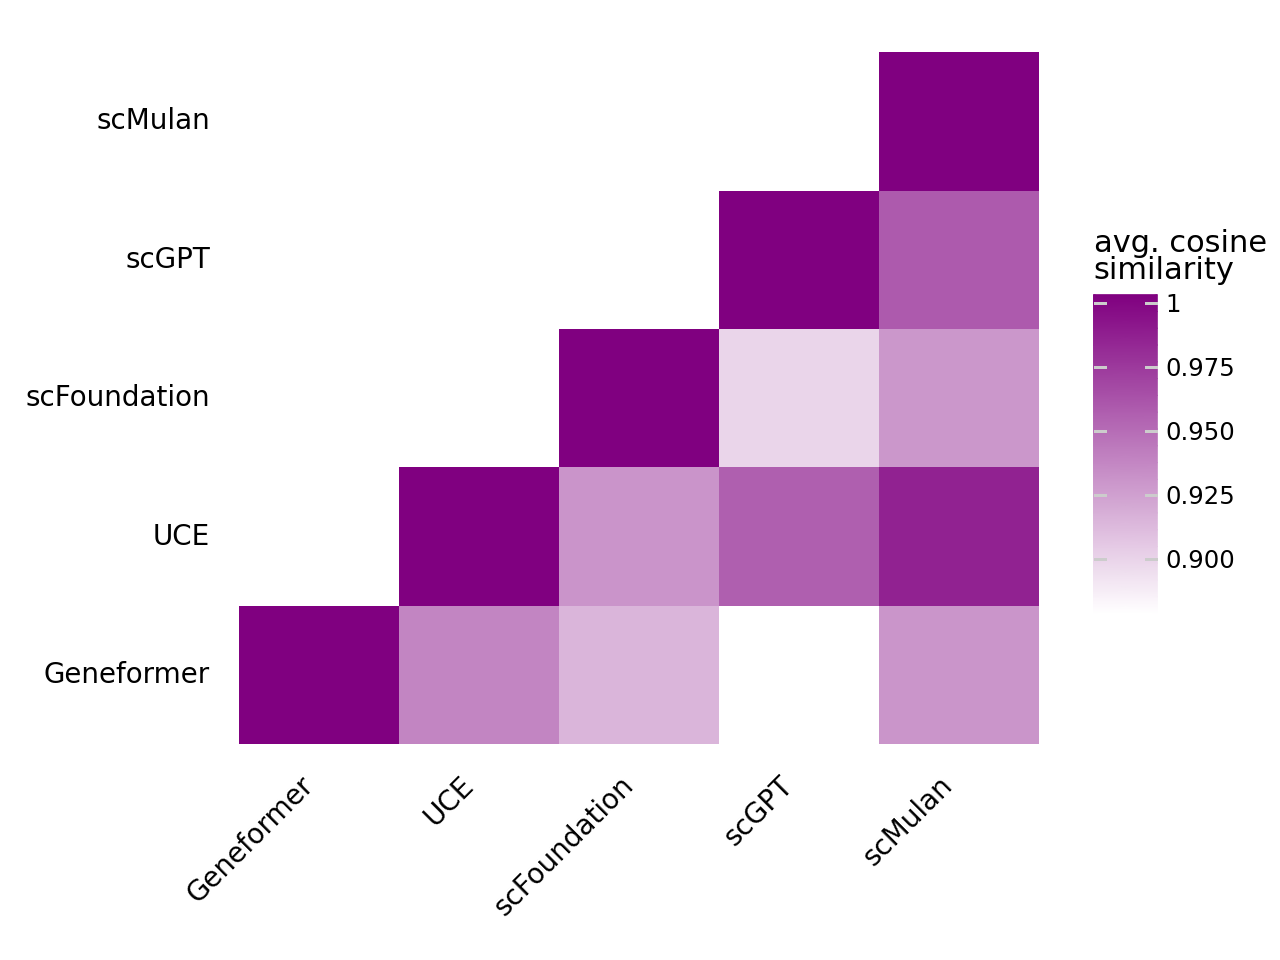

In [70]:
# sim_matrix = sim_matrix.loc[sorted(sim_matrix.index), sorted(sim_matrix.columns)]

df_long = sim_matrix.reset_index().melt(
    id_vars='index', 
    var_name='Method_col', 
    value_name='Similarity'
)
df_long = df_long.rename(columns={'index': 'Method_row'})

# --- Step 3: Filter for the lower (left) triangle (excluding the diagonal) ---
# Create an ordering dictionary based on sorted methods.
order_dict = {method: i for i, method in enumerate(sim_matrix.index.tolist())}
# Keep only rows where the row's order is greater than the column's order.
df_long = df_long[df_long['Method_row'].map(order_dict) >= df_long['Method_col'].map(order_dict)]

# --- Step 4: Create the similarity heatmap using Plotnine ---
p = (
    ggplot(df_long, aes(x='Method_col', y='Method_row', fill='Similarity'))
    + geom_tile()
    + scale_fill_gradient(low="white", high="purple")
    + labs(
        #   title="Average cosine similarity", 
          x="", 
          y="", 
          fill="avg. cosine\nsimilarity\n\n"
      )
    + theme_minimal()
    + theme(
          axis_text_x=element_text(color="black", size=10, angle=45, hjust=1),
          axis_text_y=element_text(color="black", size=10),
          axis_title_x=element_text(color="black", size=12),
          axis_title_y=element_text(color="black", size=12),
          panel_grid_major=element_blank(),
          panel_grid_minor=element_blank(),
          # Move the legend to the bottom (if desired) and adjust legend title margin:
          legend_position='right',
          # Here we add a top margin (e.g., 10 points) to move the legend title upward.
          legend_title=element_text(margin={'b':1})
      )
)

print(p)

In [3]:
cos_sim.columns = cos_sim.columns.str.replace("_","-\n")

In [4]:
df_long = pd.melt(cos_sim, id_vars=['donor'], var_name='variable', value_name='value')

In [16]:
df_long

,donor,variable,value
0,M84161,scGPT\n-scMulan,0.969597
1,M47108,scGPT\n-scMulan,0.972352
2,M2646,scGPT\n-scMulan,0.946056
3,M69259,scGPT\n-scMulan,0.964532
4,M36121,scGPT\n-scMulan,0.963241
...,...,...,...
10425,M93210,scFoundation\n-Geneformer,0.910277
10426,M41496,scFoundation\n-Geneformer,0.919138
10427,M36203,scFoundation\n-Geneformer,0.923280
10428,M12052,scFoundation\n-Geneformer,0.916040


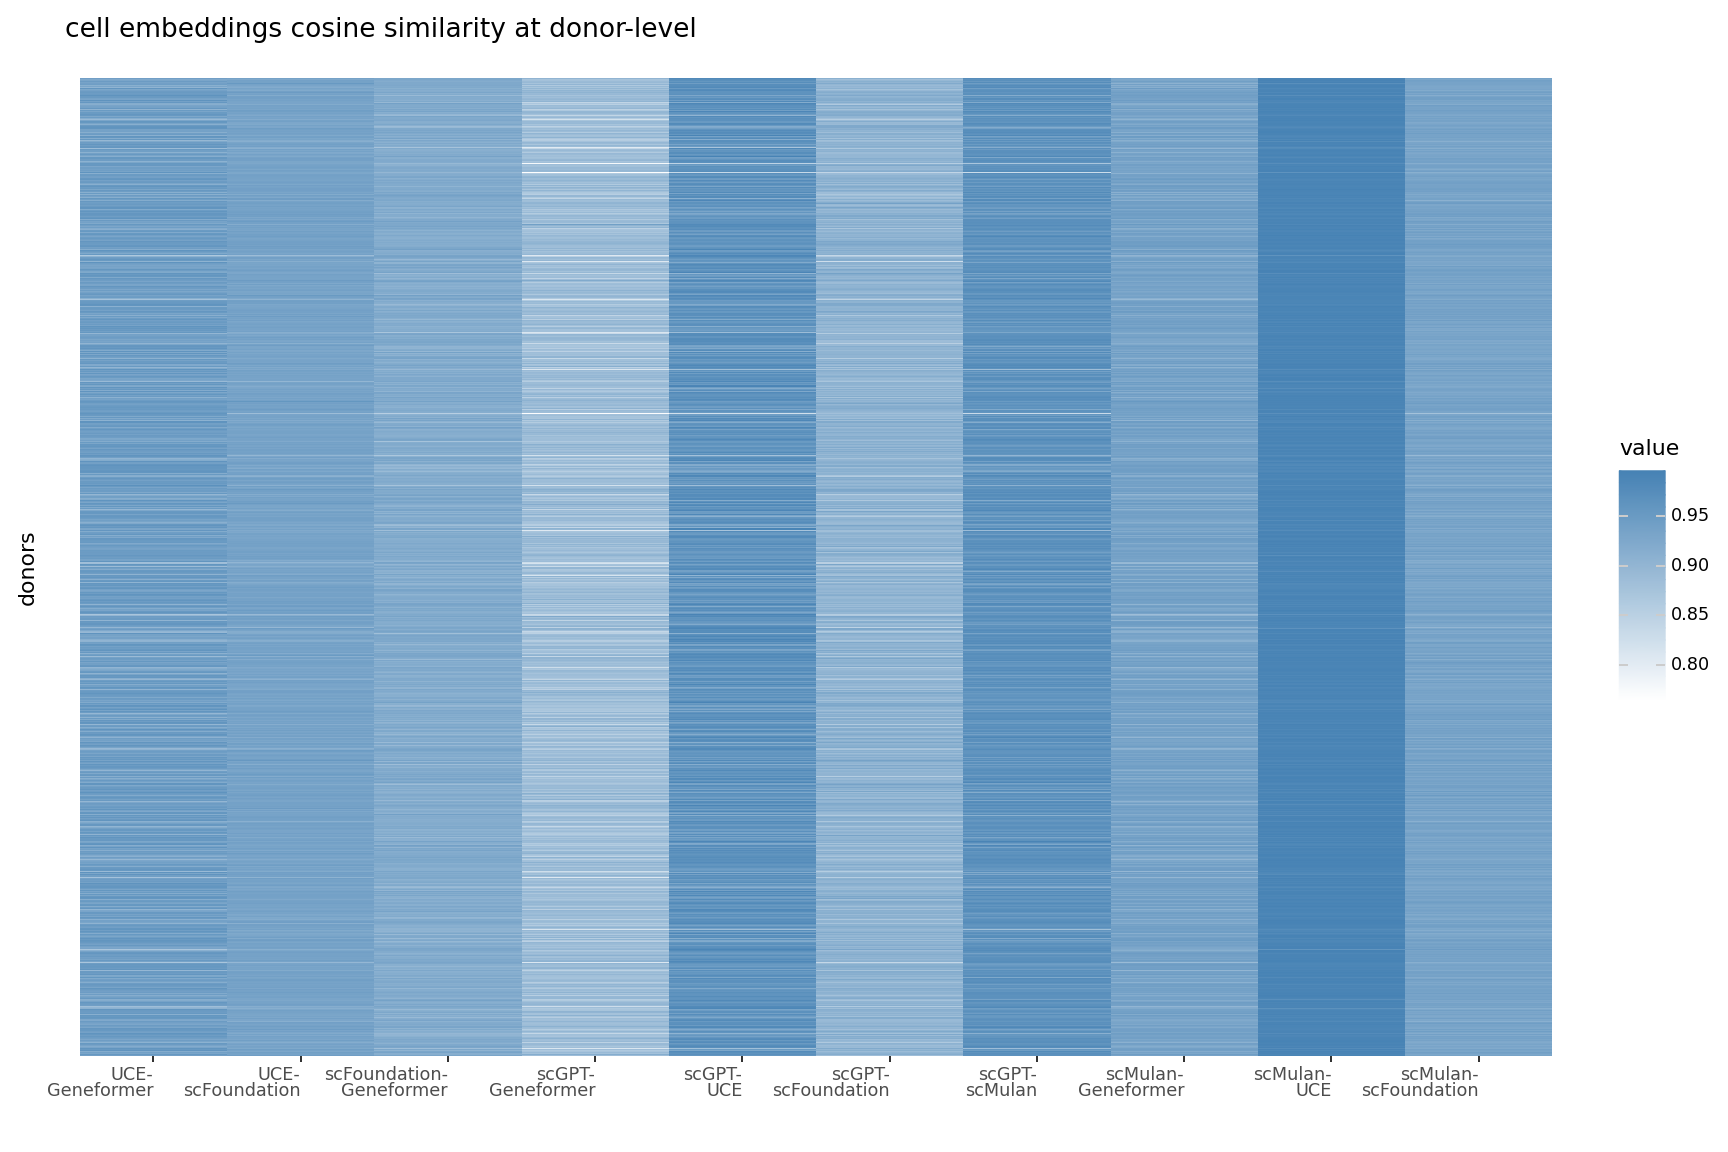

In [5]:
p = (ggplot(df_long, aes(x='variable', y='donor', fill='value'))
     + geom_tile()
     + scale_fill_gradient(low='white', high='steelblue')
     + labs(title='cell embeddings cosine similarity at donor-level', x='', y='donors')
     + theme(axis_text_x=element_text(rotation=0, hjust=1),
             axis_text_y=element_blank(),         # Remove y-axis tick labels
             axis_ticks_major_y=element_blank(),
             figure_size=(12, 8))
)
print(p)

/home/sayali/.local/lib/python3.10/site-packages/mizani/palettes.py:419: UserWarning: Warning message:Brewer palette Blues has a maximum of 9 colors Returning the palette you asked for with that many colors


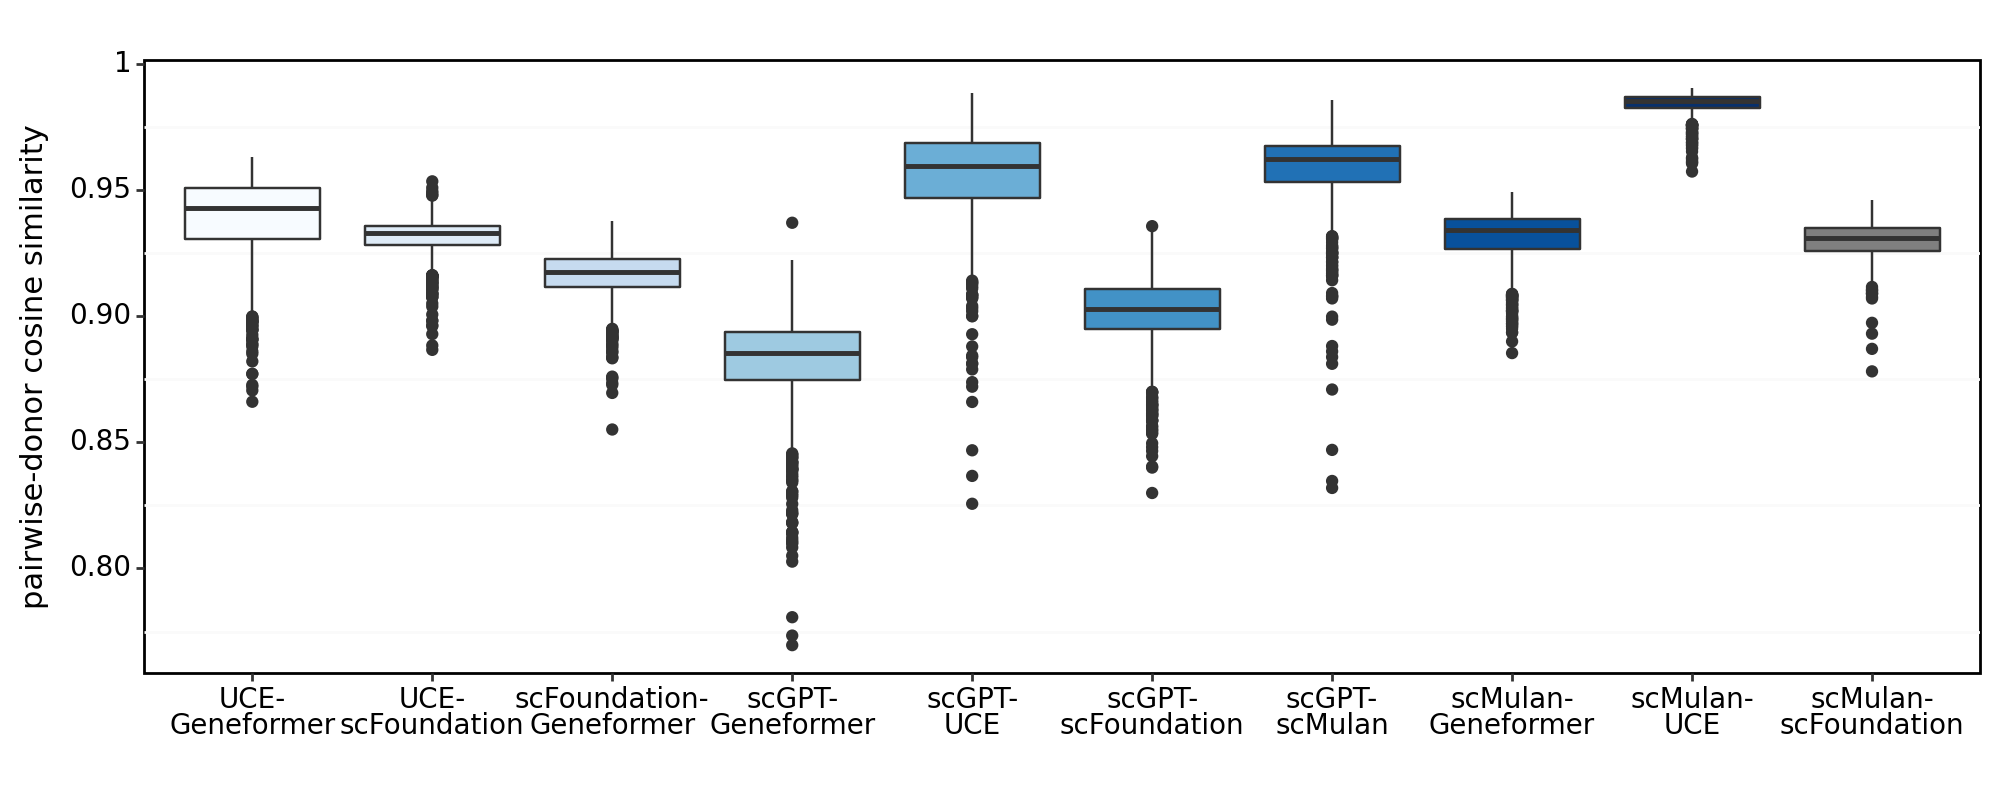

In [13]:
custom_colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', 
                 '#59A14F', '#EDC948', '#B07AA1', '#FF9DA7', 
                 '#9C755F', '#BAB0AC']

p_boxplot = (ggplot(df_long, aes(x='variable', y='value', fill="variable"))
             + geom_boxplot()
             + labs(title='', x='', y='pairwise-donor cosine similarity')
             +  theme_bw()
             + theme(
                     figure_size=(10, 4),
                     axis_text_x=element_text(rotation=0, color="black", size=10),
                    axis_text_y=element_text(color="black", size=10),
                    axis_title_x=element_text(color="black"),  # if you want x-axis title in black
                    axis_title_y=element_text(color="black"),
                      panel_grid_major = element_blank(),
                    # panel_grid_minor = element_blank(),
                    panel_border = element_rect(colour = "black"),
                    # panel_background=element_blank())
             )
             + scale_fill_brewer(type='sequential', palette='Blues',guide=False)
            # + scale_fill_manual(values=custom_colors)
            
)

print(p_boxplot)